# Basic Keyword Movie Recommender

## Dataset Creation

In [1]:
# Import libraries
import pandas as pd
import numpy as np

In [2]:
# Import 2 tables from IMDb datasets that we need
title_basics = pd.read_csv('data/title.basics.tsv.gz', sep='\t', header=0)
title_ratings = pd.read_csv('data/title.ratings.tsv.gz', sep='\t', header=0)

C:\Users\gideo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Select only movies from the title_basics table
movies = title_basics[(title_basics.titleType == 'movie')].copy()

In [4]:
# Set the indicies for our 2 tables to the IMDb key for movies
movies.set_index('tconst', inplace=True)
title_ratings.set_index('tconst', inplace=True)
# Joint the 2 tables by tconst, the IMDb key for all movies
movies_with_rating = movies.join(title_ratings, how='inner')

In [5]:
movies_with_rating.head(1)

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,,,,
tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.6,75


In [6]:
# Take only the top 10,000 movies, where we rank movies by the number of votes they have received
top_10000_movies = movies_with_rating.sort_values(by='numVotes', ascending=False)[:10000]
movies_index = top_10000_movies.index

In [7]:
top_10000_movies.shape

(10000, 10)

In [8]:
from tqdm import tqdm
from time import sleep
from imdb import IMDb

ia = IMDb()

In [9]:
keywords_dict = {}
for movie_index in tqdm(movies_index):
    sleep(1)
    try:
        keywords_dict[movie_index] = ia.get_movie_keywords(movie_index[2:])['data']['keywords']
    except:
        keywords_dict[movie_index] = ''   
        
keywords = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in keywords_dict.items() ])).transpose()
keywords = keywords.apply(lambda x: ','.join(x.dropna()), axis=1)
keywords = pd.DataFrame(keywords)
keywords.rename(columns={0:'keywords'}, inplace=True)

100%|██████████| 10000/10000 [4:17:29<00:00,  1.51s/it] 


In [10]:
# Save the plots to a CSV
keywords.to_csv(path_or_buf='Blog Post/keywords.csv')

In [11]:
# Load our keywords for the CSV
keywords = pd.read_csv('Blog Post/keywords.csv')
keywords.rename(columns={'Unnamed: 0':'tconst'}, inplace=True)
keywords.set_index('tconst', inplace=True)

In [12]:
# Join to our table
movies = top_10000_movies.join(keywords, how='inner')

In [13]:
# Save our dataframe to a CSV if you don't want to re-run the loop
movies.to_csv(path_or_buf='Blog Post/movies_keywords.csv')

## Keyword EDA

In [14]:
# Import movies table and set the index if you need
# movies = pd.read_csv('Blog Post/movies_keywords.csv')
# movies.set_index('tconst', inplace=True)

In [15]:
movies = movies[movies.keywords.notnull()]

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

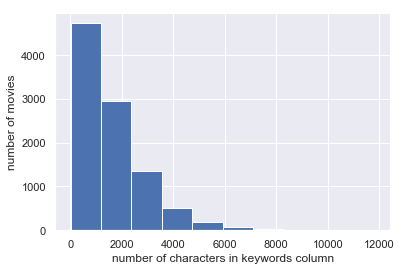

In [17]:
number_of_keyword_chars = []
for keywords in movies['keywords']:#[:10000]:
    n_chars = len(keywords)
    number_of_keyword_chars.append(n_chars)


plt.hist(number_of_keyword_chars)
plt.xlabel('number of characters in keywords column')
plt.ylabel('number of movies')
plt.show()

In [18]:
print("keywords: %.3f" %(np.mean(movies['keywords'].str.len())) )

keywords: 1606.855


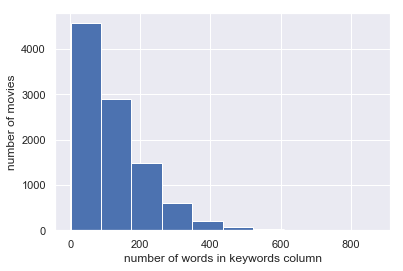

In [19]:
number_of_keywords = []
for keywords in movies['keywords']:
    n_keywords = len(keywords.split(','))
    number_of_keywords.append(n_keywords)

plt.hist(number_of_keywords)
plt.xlabel('number of words in keywords column')
plt.ylabel('number of movies')
plt.show()

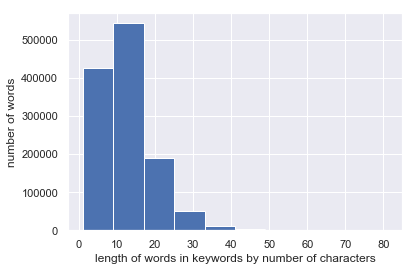

In [20]:
keyword_lengths = []
for keywords in movies['keywords']:
    keywords = keywords.split(',')
    for keyword in keywords:
        keyword_lengths.append(len(keyword))
        
plt.hist(keyword_lengths)
plt.xlabel('length of words in keywords by number of characters')
plt.ylabel('number of words')
plt.show()

## Modelling

In [21]:
# Import movies table and set the index
#movies = pd.read_csv('Blog Post/movies_keywords.csv')

In [22]:
movies.reset_index(inplace=True)
movies = movies[['primaryTitle', 'keywords']]

In [23]:
# Processing Keywords
keywords = movies['keywords'].tolist()

from nltk.tokenize import word_tokenize
keywords = [word_tokenize(keyword.lower()) for keyword in keywords]

def no_commas(doc):
    no_commas = [t for t in doc if t!=',']
    return(no_commas)

keywords = [no_commas(kw) for kw in keywords]
processed_keywords = keywords

In [24]:
#To save processed keywords
# import csv
# with open('Blog Post/processed_keywords.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(processed_keywords)
# csvFile.close()

In [25]:
# To import processed keywords
# with open('Blog Post/processed_keywords.csv', 'r') as f:
#     reader = csv.reader(f)
#     processed_keywords = list(reader)
# processed_keywords = processed_keywords[0::2] # get rid of empty lists

### 1st Mode: tf-idf with cosine similarity

In [26]:
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(processed_keywords) # create a dictionary of words from our keywords

corpus = [dictionary.doc2bow(doc) for doc in processed_keywords] 
#create corpus where the corpus is a bag of words for each document

from gensim.models.tfidfmodel import TfidfModel
tfidf = TfidfModel(corpus) #create tfidf model of the corpus

from gensim.similarities import MatrixSimilarity
# Create the similarity data structure. This is the most important part where we get the similarities between the movies.
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))

C:\Users\gideo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [27]:
def movie_recommendation(movie_title, number_of_hits=5):
    movie = movies.loc[movies.primaryTitle==movie_title] # get the movie row
    keywords = movie['keywords'].iloc[0].split(',') #get the keywords as a Series (movie['keywords']),
    # get just the keywords string ([0]), and then convert to a list of keywords (.split(',') )
    query_doc = keywords #set the query_doc to the list of keywords
    
    query_doc_bow = dictionary.doc2bow(query_doc) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the movie ID and it's tf-idf value for the movie

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our movie and every other movie. 
    #So the length is the number of movies we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=movies.primaryTitle.values) #Convert to a Series
    top_hits = similarity_series.sort_values(ascending=False)[1:number_of_hits+1] 
    #get the top matching results, i.e. most similar movies; start from index 1 because every movie is most similar to itself

    #print the words with the highest tf-idf values for the provided movie:
    sorted_tfidf_weights = sorted(tfidf[corpus[movie.index.values.tolist()[0]]], key=lambda w: w[1], reverse=True)
    print('The top 5 words associated with this movie by tf-idf are: ')
    for term_id, weight in sorted_tfidf_weights[:5]:
        print(" '%s' with a tf-idf score of %.3f" %(dictionary.get(term_id), weight))
    
    # Print the top matching movies
    print("Our top %s most similar movies for movie %s are:" %(number_of_hits, movie_title))
    for idx, (movie,score) in enumerate(zip(top_hits.index, top_hits)):
        print("%d %s with a similarity score of %.3f" %(idx+1, movie, score))

In [28]:
movie_recommendation('The Shawshank Redemption', 5)

The top 5 words associated with this movie by tf-idf are: 
 'boom-shot' with a tf-idf score of 0.090
 'fresh-fish' with a tf-idf score of 0.090
 'killed-by-prison-guard' with a tf-idf score of 0.090
 'library-cart' with a tf-idf score of 0.090
 'missing-prisoner' with a tf-idf score of 0.090
Our top 5 most similar movies for movie The Shawshank Redemption are:
1 Stir Crazy with a similarity score of 0.075
2 Escape from Alcatraz with a similarity score of 0.065
3 Lock Up with a similarity score of 0.065
4 The Last Castle with a similarity score of 0.063
5 Anything for Her with a similarity score of 0.058


In [29]:
def keywords_recommendation(keywords, number_of_hits):
    query_doc_bow = dictionary.doc2bow(keywords) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the movie ID and it's tf-idf value for the movie

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our movie and every other movie. 
    #So the length is the number of movies we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=movies.primaryTitle.values) #Convert to a Series
    top_hits = similarity_series.sort_values(ascending=False)[:number_of_hits] #get the top matching results, 
    # i.e. most similar movies

    # Print the top matching movies
    print("Our top %s most similar movies for the keywords %s are:" %(number_of_hits, keywords))
    for idx, (movie,score) in enumerate(zip(top_hits.index, top_hits)):
        print("%d '%s' with a similarity score of %.3f" %(idx+1, movie, score))

In [30]:
keywords_recommendation(['wrongful-imprisonment','escape-from-prison','based-on-the-works-of-stephen-king',
                         'prison', 'voice-over-narration', 'caged-bird','reference-to-fort-hancock-texas','aria'], 5)

Our top 5 most similar movies for the keywords ['wrongful-imprisonment', 'escape-from-prison', 'based-on-the-works-of-stephen-king', 'prison', 'voice-over-narration', 'caged-bird', 'reference-to-fort-hancock-texas', 'aria'] are:
1 'The Shawshank Redemption' with a similarity score of 0.161
2 'Down by Law' with a similarity score of 0.151
3 'Old Men in New Cars: In China They Eat Dogs II' with a similarity score of 0.094
4 'Diva' with a similarity score of 0.093
5 'I Am a Fugitive from a Chain Gang' with a similarity score of 0.088


### 2nd Model: Word counts with cosine similarity

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
def get_vectors(text):
    vectorizer = CountVectorizer(text)
    X = vectorizer.fit_transform(text).toarray()
    return(X)
vectors = get_vectors(movies.keywords.tolist())

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_recommender(movie_title, number_of_hits=5):
    movie_index = movies[movies.primaryTitle == movie_title].index.values[0]

    cosines = []
    for i in range(len(vectors)):
        vector_list = [vectors[movie_index], vectors[i]]
        cosines.append(cosine_similarity(vector_list)[0,1])

    cosines = pd.Series(cosines)
    index = cosines.nlargest(number_of_hits+1).index

    matches = movies.loc[index]
    for match,score in zip(matches['primaryTitle'][1:],cosines[index][1:]):
        print(match,score )

In [33]:
cosine_recommender('The Shawshank Redemption')

Kill Your Friends 0.7855282815475104
Operation Finale 0.7788741747158128
The Riot Club 0.7770743665821798
Patti Cake$ 0.7712903489701683
Girls Trip 0.7707531149313526


### 3rd Model: Jaccard Similarity

In [34]:
def get_jaccard_sim(str1, str2):
    a = set(str1.split(','))
    b = set(str2.split(','))
    c = a.intersection(b)
    return(float(len(c)) / (len(a) + len(b) - len(c)))

def jaccard_recommender(movie_title, number_of_hits=5):
    movie = movies[movies.primaryTitle==movie_title]
    keyword_string = movie.keywords.iloc[0]

    jaccards = []
    for movie in movies['keywords']:
        jaccards.append(get_jaccard_sim(keyword_string, movie))
    jaccards = pd.Series(jaccards)
    jaccards_index = jaccards.nlargest(number_of_hits+1).index
    matches = movies.loc[jaccards_index]
    for match,score in zip(matches['primaryTitle'][1:],jaccards[jaccards_index][1:]) :
        print(match,score )

In [35]:
jaccard_recommender('The Shawshank Redemption')

Lock Up 0.07053941908713693
The Getaway 0.06299212598425197
Boy A 0.0626118067978533
Character 0.060665362035225046
Call Northside 777 0.06
